In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')

The data for this notebook is the same as for the previous Closed Loop integral, but it has also been symmetrized with respect to the AP direction as well (I can send this if necessary)

(31, 4, 236, 200) (31, 236, 200) (31, 2, 236, 200)


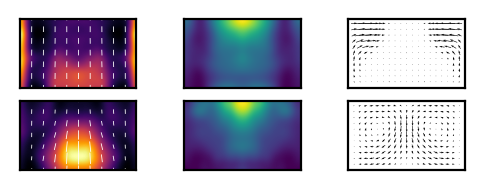

In [2]:
# Load data 
m0 = np.load('test_data/myosin.npy', mmap_mode='r')
c0 = np.load('test_data/cadherin.npy', mmap_mode='r').squeeze()
v0 = np.load('test_data/velocity.npy', mmap_mode='r')
t0 = np.load('test_data/time.npy', mmap_mode='r')

print(m0.shape, c0.shape, v0.shape)

def symmetrize(f):
    f_lr = f[..., ::-1, :].copy()
    if f.shape[1] == 4:
        f_lr[:, 1:3] *= -1
    elif f.shape[1] == 2:
        f_lr[:, 0] *= -1
    f = 0.5 * (f + f_lr)
    
    f_ap = f[..., ::-1].copy()
    if f.shape[1] == 4:
        f_ap[:, 1:3] *= -1
    elif f.shape[1] == 2:
        f_ap[:, 1] *= -1
    f = 0.5 * (f + f_ap)
    
    return f
    

m0 = symmetrize(np.load('../for_michel/data/myosin.npy', mmap_mode='r'))
c0 = symmetrize(np.load('../for_michel/data/cadherin.npy', mmap_mode='r')).squeeze()
v0 = symmetrize(np.load('../for_michel/data/velocity.npy', mmap_mode='r'))
t0 = np.load('../for_michel/data/time.npy', mmap_mode='r')

    
from utils.plot_utils import *
fig, ax = plt.subplots(2, 3, figsize=(3, 1), dpi=200)
plot_tensor2D(ax[0, 0], m0[0])
plot_tensor2D(ax[1, 0], m0[-1])
color_2D(ax[0, 1], c0[0])
color_2D(ax[1, 1], c0[-1])
plot_vector2D(ax[0, 2], v0[0])
plot_vector2D(ax[1, 2], v0[-1])

We use the Fenics library for the finite element implementation. This cell demonstrates how to map from the image data to the Fenics Function interface

Plotting function
Plotting function


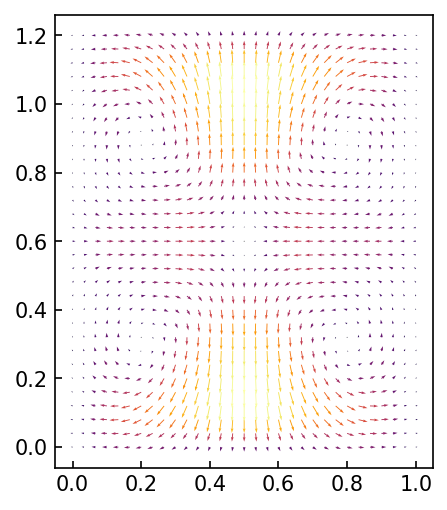

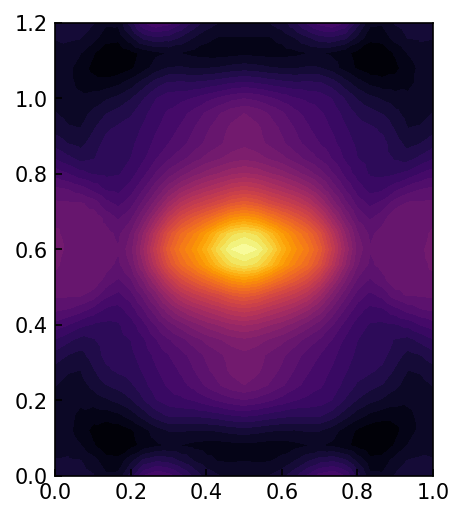

In [3]:
#Set up fenics problem - periodic BCs in both directions
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.interpolate import RectBivariateSpline, griddata

class MeshInterpolator(BaseEstimator, TransformerMixin):
    '''
    Interpolate fields to fenics functions or back to regular grids
    '''
    def __init__(self, mesh=None):
        self.mesh = mesh
    
    def fit(self, X, y=None):
        self.nDV_ = X.shape[-2]
        self.nAP_ = X.shape[-1]
        
        self.verts = self.mesh.coordinates().T
        self.dv_min_ = self.verts[1].min()
        self.dv_max_ = self.verts[1].max()
        self.ap_min_ = self.verts[0].min()
        self.ap_max_ = self.verts[0].max()

        return self
    
    def transform(self, X):
        x0 = X.reshape([-1, *X.shape[-2:]])

        #Interpolate to vertex points
        AP = np.linspace(self.ap_min_, self.ap_max_, X.shape[-1])
        DV = np.linspace(self.dv_min_, self.dv_max_, X.shape[-2])

        x1 = []
        for i in range(x0.shape[0]):
            xi = RectBivariateSpline(DV, AP, x0[i])(self.verts[1], self.verts[0], grid=False)
            x1.insert(0, xi) #Reverse order to X-Y instead of Y-X
        x1 = np.stack(x1)
                
        if x1.shape[0] == 1:
            FS = FunctionSpace(self.mesh, 'CG', 1)
        elif x1.shape[0] == 2:
            FS = VectorFunctionSpace(self.mesh, 'CG', 1)
        else:
            FS = TensorFunctionSpace(self.mesh, 'CG', 1)
        f = Function(FS)
        d2v = dof_to_vertex_map(FS)
        f.vector().set_local(x1.T.flatten()[d2v])
        return f

    def inverse_transform(self, X, FS):
        f = Function(FS)
        f.vector().set_local(X)
        x0 = f.compute_vertex_values().reshape([-1, self.verts.shape[1]])
        
        AP = np.linspace(self.ap_min_, self.ap_max_, self.nAP_)[None, :]
        DV = np.linspace(self.dv_min_, self.dv_max_, self.nDV_)[:, None]
        x1 = []
                
        for i in range(x0.shape[0]):
            xi = griddata((self.verts[1], self.verts[0]), x0[i], (DV, AP), method='nearest')
            x1.insert(0, xi)
            
        x1 = np.stack(x1)
        return x1
    
from fenics import *
from scipy.interpolate import RectBivariateSpline

width, height = 1, 1.2
mesh = RectangleMesh(Point(0., 0.), Point(width, height), 30, 30)
verts = mesh.coordinates()
dv = np.linspace(0, height, m0.shape[-2])
ap = np.linspace(0, width,  m0.shape[-1])
    
# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return bool(
            (near(x[0], 0) or near(x[1], 0)) and
            (not ((near(x[0], 0) and near(x[1], height)) or
                  (near(x[0], width) and near(x[1], 0)))) and
            on_boundary)

    def map(self, x, y):
        if near(x[0], width) and near(x[1], height):
            y[0] = x[0] - width
            y[1] = x[1] - height
        elif near(x[0], width):
            y[0] = x[0] - width
            y[1] = x[1]
        elif near(x[1], height):
            y[0] = x[0]
            y[1] = x[1] - height
        else:
            y[0] = -1000
            y[1] = -1000

t = TensorElement('Lagrange', mesh.ufl_cell(), 1)
v = VectorElement('Lagrange', mesh.ufl_cell(), 2)
s = FiniteElement('Lagrange', mesh.ufl_cell(), 1)
th = v * s
TH = FunctionSpace(mesh, th, constrained_domain=PeriodicBoundary())
V = FunctionSpace(mesh, v, constrained_domain=PeriodicBoundary())
T = FunctionSpace(mesh, t, constrained_domain=PeriodicBoundary())

interp = MeshInterpolator(mesh).fit(v0[20])
plt.figure(dpi=150)
f = interp.transform(v0[20])
plot(f)

plt.figure(dpi=150)
c = interp.transform(c0[20])
plot(c)

There are two things to calibrate. First, for some unknown reason Fenics breaks if the spatial coordinates of the mesh are larger than ~5. So we have to track the spatial scale relative to that of the data (which is in microns) and adjust the gradients accordingly.

Second, we only know that the forcing is proportional to $\nabla \cdot m$ and so we need to find a coefficient so that the flow has the right magnitude. In this cell we show that a choice of this prefactor $\alpha$ yields reasonable agreement

Assembling Stokes flow problem


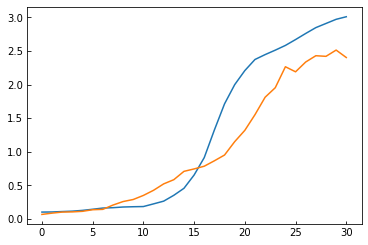

In [4]:
#Calibrate flow model
m = Function(T) #Myosin
vp = Function(TH) #Velocity + Pressure

alpha = 3 #prefactor for div(m) in Stokes equation
#Space scale is a multiplicative factor which appears every time we take a gradient
space_scale = 1 / (0.5 * ((dv_max-dv_min)/height + (ap_max-ap_min)/width))

print('Assembling Stokes flow problem')
u, p = TrialFunctions(TH)
v, q = TestFunctions(TH)
a = space_scale * (
    space_scale * inner(grad(u), grad(v)) * dx + \
    div(v) * p * dx + \
    q * div(u) * dx)
Av = assemble(a)
Lv = space_scale * alpha * inner(div(m), v) * dx

vels = []
for mi in m0:
    mn = project(interp.transform(mi), T)
    m.vector().set_local(mn.vector()[:])
    L = assemble(Lv)
    solve(Av, vp.vector(), L)
    v1, p = vp.split()
    v1 = project(v1, V).vector()[:]
    vels.append(interp.inverse_transform(v1, V))

vels = np.stack(vels)

plt.plot(np.linalg.norm(v0, axis=1).mean(axis=(1, 2)))
plt.plot(np.linalg.norm(vels, axis=1).mean(axis=(1, 2)))

Integration of the finite-element system from toy initial conditions. We rescale coefficients as necessary accounting for the discrepancy in the spatial scale. It's not perfect, but it seems to work.

In [5]:
import torch
from torch import nn

import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, NotFittedError
from scipy.integrate import solve_ivp
from scipy.interpolate import RectBivariateSpline, griddata
from fenics import *

class InputProcessor(BaseEstimator, TransformerMixin):
    '''
    Proceses inputs and shapes them correctly
    '''
    def __init__(self, domains=None):
        self.domains = domains
        
    def fit(self, X, y=None):
        self.data_shape_ = [ d.dim() for d in self.domains ]
        return self
        
    def transform(self, X):
        X = X.reshape([-1, np.sum(self.data_shape_)])
        X = np.split(X, np.cumsum(self.data_shape_), axis=-1)
        return X
        
    def inverse_transform(self, X):
        for i in range(len(self.data_shape_)):
            X[i] = X[i].reshape([-1, self.data_shape_[i]])
        X = np.concatenate(X, axis=-1)
        X = X.flatten()
        return X
    
def strain_rate(v):
    return 0.5 * (grad(v) + grad(v).T)

def vorticity(v):
    return 0.5 * (grad(v) - grad(v).T)

def commutator(t1, t2):
    return dot(t1, t2) - dot(t2, t1)

class FenicsFlyLoop(BaseEstimator):
    '''
    A closed fly loop can use scipy solve_ivp and fenics to integrate
    a machine-learned equation of motion from initial conditions using the fly
    '''
    def __init__(self, mesh=mesh, pbc=PeriodicBoundary()):
        self.mesh = mesh
        self.pbc  = pbc
        
    def fit(self, X, y0=None):
        #Build function spaces
        t = TensorElement('Lagrange', self.mesh.ufl_cell(), 1)
        v = VectorElement('Lagrange', self.mesh.ufl_cell(), 2)
        s = FiniteElement('Lagrange', self.mesh.ufl_cell(), 1)
        th = v * s
        self.TH = FunctionSpace(self.mesh, th, constrained_domain=self.pbc)
        self.S = FunctionSpace(self.mesh, s, constrained_domain=self.pbc)
        self.V = FunctionSpace(self.mesh, v, constrained_domain=self.pbc)
        self.T = FunctionSpace(self.mesh, t, constrained_domain=self.pbc)
        
        #Pre-allocate functions and constants
        self.m = Function(self.T) #Myosin
        self.c = Function(self.S) #Cadherin
        self.vp = Function(self.TH) #Velocity + Pressure
        
        self.cdot = Function(self.S)
        self.mdot = Function(self.T)
        gamma_dv = Constant(((0., 0.), (0., 1.)))
        
        alpha = 3 #prefactor for div(m) in Stokes equation
        #Space scale is a multiplicative factor which appears every time we take a gradient
        space_scale = 1 / (0.5 * ((dv_max-dv_min)/height + (ap_max-ap_min)/width))
        
        print('Assembling Stokes flow problem')
        u, p = TrialFunctions(self.TH)
        v, q = TestFunctions(self.TH)
        a = space_scale * inner(grad(u), grad(v)) * dx + div(v) * p * dx + q * div(u) * dx
        self.Av = assemble(a)
        self.Lv = alpha * inner(div(self.m), v) * dx
        
        
        print('Assembling cadherin advection problem')
        s, t = TrialFunction(self.S), TestFunction(self.S)
        self.Ac = assemble(inner(s, t) * dx)
        self.Lc = -space_scale * inner(dot(self.vp.sub(0), grad(self.c)), t) * dx
        
        print('Assembling myosin problem')
        t, u = TrialFunction(self.T), TestFunction(self.T)
        self.Am = assemble(inner(t, u) * dx)
        lhs = space_scale * inner(dot(self.vp.sub(0), grad(self.m)), u) * dx + \
              space_scale * inner(commutator(vorticity(self.vp.sub(0)), self.m), u) * dx
        rhs = -inner((0.066 - 0.061 * self.c) * self.m, u) * dx + \
               space_scale * inner((0.489 + 0.318 * self.c) * self.m * div(self.vp.sub(0)), u) * dx + \
               inner((0.564 - 0.393 * self.c) * self.m * tr(self.m), u) * dx + \
               inner((0.047 - 0.037 * self.c) * tr(self.m) * gamma_dv, u) * dx
        self.Lm = -lhs + rhs
        
        #Input processing
        self.inputs = InputProcessor([self.T, self.S]).fit(X)
        
        return self
    
    def solve_stokes_flow(self, m):
        self.m.vector().set_local(m.flatten())
        L = assemble(self.Lv)
        solve(self.Av, self.vp.vector(), L)
    
    def solve_cadherin_advection(self, c):
        self.c.vector().set_local(c.flatten())
        L = assemble(self.Lc)
        solve(self.Ac, self.cdot.vector(), L)

    def solve_myosin_problem(self):
        L = assemble(self.Lm)
        solve(self.Am, self.mdot.vector(), L)

    def forward(self, t, y):        
        #Get myosin and source
        m, c, _ = self.inputs.transform(y)
        
        self.solve_stokes_flow(m)
        self.solve_cadherin_advection(c)
        self.solve_myosin_problem()
        
        cdot = self.cdot.vector()[:]
        mdot = self.mdot.vector()[:]

        ydot = self.inputs.inverse_transform([mdot, cdot])
        return ydot

    def integrate(self, y0, t):
        y = solve_ivp(self.forward, [t[0], t[-1]], y0, method='RK45', t_eval=t)['y'].T
        m, c, _ = self.inputs.transform(y)
        v = []
        for mi in m:
            self.solve_stokes_flow(mi)
            v1, p = self.vp.split()
            v1 = project(v1, self.V)
            v.append(v1.vector()[:])
        v = np.stack(v)
        return m, c, v
    
width, height = 1, 1.2
mesh = RectangleMesh(Point(0., 0.), Point(width, height), 54, 48)
pbc = PeriodicBoundary()

verts = mesh.coordinates()
dv = np.linspace(0, height, m0.shape[-2])
ap = np.linspace(0, width,  m0.shape[-1])

interp = MeshInterpolator(mesh).fit(m0[0])
model = FenicsFlyLoop(mesh, pbc).fit(None)
m = project(interp.transform(m0[5]), model.T)
c = project(interp.transform(c0[5]), model.S)
y0 = np.concatenate([m.vector()[:], c.vector()[:]])
m, c, v = model.integrate(y0, np.linspace(0, 15, 5))
print(m.shape, c.shape, v.shape)
print('Done')

Assembling Stokes flow problem
Assembling cadherin advection problem
Assembling myosin problem
(5, 10368) (5, 2592) (5, 20736)
Done


Plot a time series of integrated myosin, cadherin, and flow profiels. For some reason cadherin doesn't seem to change much. This is the case in practice, although here it actaully seems to be completely static.

Text(0, 0.5, 'Velocity')

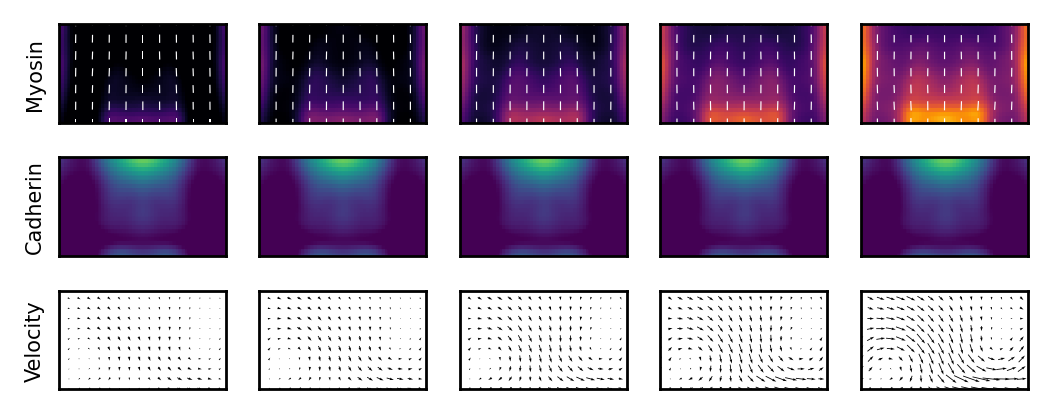

In [6]:
plt.rcParams['figure.dpi'] = 250
plt.rcParams['font.size'] = 6
fig, ax = plt.subplots(3, 5, dpi=250, figsize=(5, 2))

for i in range(m.shape[0]):
    m1 = interp.inverse_transform(m[i], model.T)
    plot_tensor2D(ax[0, i], m1, vmin=0.075, vmax=0.15)

    c1 = interp.inverse_transform(c[i], model.S)
    color_2D(ax[1, i], c1, vmin=1, vmax=1.8)

    v1 = interp.inverse_transform(v[i], model.V)
    plot_vector2D(ax[2, i], v1, scale=1e1, skip=12)
    
ax[0, 0].set_ylabel('Myosin')
ax[1, 0].set_ylabel('Cadherin')
ax[2, 0].set_ylabel('Velocity')

(5, 10368) (5, 2592) (5, 20736)
Done


Text(0, 0.5, 'Velocity')

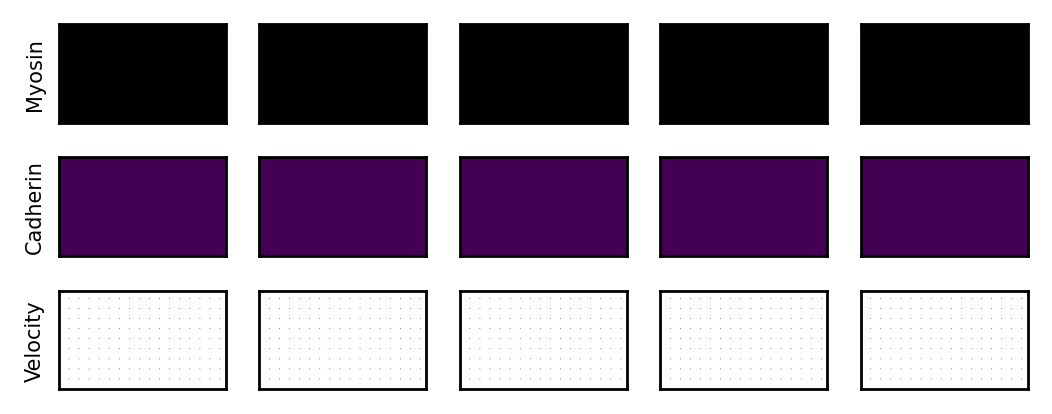

In [7]:
m = project(interp.transform(np.zeros_like(m0[5])), model.T)
c = project(interp.transform(np.zeros_like(c0[5])), model.S)
y0 = np.concatenate([m.vector()[:], c.vector()[:]])
m, c, v = model.integrate(y0, np.linspace(0, 15, 5))
print(m.shape, c.shape, v.shape)
print('Done')

fig, ax = plt.subplots(3, 5, dpi=250, figsize=(5, 2))

for i in range(m.shape[0]):
    m1 = interp.inverse_transform(m[i], model.T)
    plot_tensor2D(ax[0, i], m1, vmin=0.075, vmax=0.15)

    c1 = interp.inverse_transform(c[i], model.S)
    color_2D(ax[1, i], c1, vmin=1, vmax=1.8)

    v1 = interp.inverse_transform(v[i], model.V)
    plot_vector2D(ax[2, i], v1, scale=1e1, skip=12)
    
ax[0, 0].set_ylabel('Myosin')
ax[1, 0].set_ylabel('Cadherin')
ax[2, 0].set_ylabel('Velocity')